<a href="https://colab.research.google.com/github/ivyclare/PrivateAI/blob/master/COVID_PATE_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting an Invisible Enemy With Invisible Data
### Detecting COVID19 through Differential Privacy 

Imagine you work as a DL researcher in a hospital and your job is to find ways to assist doctors in their fight against diseases. Due to the coronavirus (the invisible enemy) pandemic, there is a growing number of patients and a pool of CT images waiting to be diagnosed. You decide to create an image classifier, which would not only reduce the burden on clinicians and help them make more informed decisions, but also lead to faster diagnosis and potentially save lives. However, there is a challenge; **your CT Images are not labelled**. 

It comes to your attention that 5 other hospitals have annotated ("positive" or "negative" for COVID 19) CT scans, which is exactly what you need. Even though these hospitals are willing to help, they have privacy concerns about sharing the information of their patients and so cannot give out the data. How can you make use of these datasets without accessing them directly? How can you assure these hospitals that their patients' data will be protected? Is it even a possibility? We try to answer these questions in this blog post.

Spoiler alert! Yes, it is possible :).  

We are not only going to learn how this is possible, we are also going to do a hands-on implementation with a COVID-19 dataset. 


Let me introduce you to Alice. Alice is the head of a DL research team in a hospital and her job is to find ways to assist doctors in their fight against diseases. Due to the coronavirus(the invisible enemy) pandemic, there is a growing number of patients and  a pool of CT images waiting to be diagnosed. She decides to create an image classifier which would not only reduce the burden on clinicians and help them make more informed decisions, it would also lead to faster diagnosis and potentially save lives. However, there is a challenge; **her CT Images are not labelled**. 

It comes to her attention that 5 other hospitals have annotated (positive or negative for COVID 19) CT scans which is exactly what she needs. Even though these hospitals are willing to help, they have privacy concerns about sharing information about their patients and so cannot give out the data. How can Alice make use of these datasets without accessing them directly? How can she assure these hospitals that the patients data will be protected? Is it even a possibility?. We try to answer these questions in this blog post and help Alice solve her problem.

Spoiler alert! Yes, it is possible :). 

We are not only going to learn how this is possible, we are also going to do a hands on implementation on a COVID-19 dataset. 


### Goal
Preserve privacy of training data (data from partner hospitals) when building a deep learning model. 



### Solution

The solution to our problem lies in a privacy preserving method called differential privacy. We will focus on PATE Analysis, specifically. Don't worry if you are not familiar with these terms as we will introduce these concepts first. 

What is differential privacy?

Differential privacy is a notion of privacy that was introduced by Cynthia Dwork et al.[1](https://link.springer.com/chapter/10.1007/11681878_14) which ensures that statistical analysis does not compromise privacy. 
It makes sure that the effect that an individual's data has on the overall model output is limited. In other words, the output of an algorithm is pretty much the same, with or without the data of a specific individual in the dataset.

## ADD IMAGE HERE
[Source](http://www.cleverhans.io/privacy/2018/04/29/privacy-and-machine-learning.html)

As can be seen in the image above, John's information is present in the first dataset and absent in the second but the model output is the same. The intuition here is that an adversary who wants to get John's data can't determine whether or not John is present in the dataset - let alone the contents of his data. Hence, John's privacy is guaranteed. 

Differential privacy typically works by adding statistical noise either at the input level (local differential privacy) or the output level (global differential privacy) of the model or statistical query. The addition of noise guarantees that individual user contributions are concealed but at the same time we gain insights into the overall population without sacrificing privacy. The amount of noise added is dependent on a parameter called the **privacy budget**  which is often denoted by epsilon (ε). The smaller the value of epsilon is (i.e more noise added), the higher the privacy it provides and vice versa. As shown in the image below, we can see that as more noise is added to the face image, the more anonymous it gets but the less useful it becomes. Hence, choosing the right epsilon value is very important.

 ### IMAGE HERE - TRADEOFF
[Source](https://aircloak.com/explaining-differential-privacy/)


The differential privacy method we are going to use is called PATE (**Private Aggregation of Teacher Ensembles**) which was proposed by Papernot et al. [(3)](https://arxiv.org/pdf/1610.05755.pdf). The PATE framework is similar to any other supervised machine learning approach but the resulting model here guarantees privacy. The following paragraph gives some insight into how the PATE framework works:

First, several models are obtained from training disjoint datasets, which have no training examples in common. These models are called teacher models. An input is then sent into all these teacher models and they each produce an output, typically a class label. The final class of the input image is the aggregate of the output of all teacher models.

If all/most models agreed on a particular class, then it is easy to conclude the class of the input. 
This means that no private information is leaked about any single training example because if any training example is removed from one of the datasets, the models will still agree on the same output. In this case, the privacy budget is low and the algorithm satisfies differential privacy. 

On the other hand, if the models disagree (hence a high privacy budget), this can lead to confusion about what class the input image belongs to and can eventually lead to privacy leakage. In order to solve this problem, we apply the Report Noisy Max (RNM) algorithm, which adds random noise to the output of each model. This method provides a meaningful and strong privacy guarantee. At this juncture, the algorithm is completely differentially private. 

The beauty of PATE analysis is that it does not just end here; it goes an extra mile to increase privacy. 

There are 2 main reasons why we cannot use the aggregate teacher models for inference:
1. Every time we make a prediction, the privacy budget increases. Therefore, we will eventually reach a point where privacy leaks will be inevitable. 
2. Through multiple querying or model inspection, an adversary can access the training data of the teachers which will be disastrous. 

For these reasons, creating a student model becomes a necessity. The student model is a public unlabelled dataset that can now be labelled with the teacher models. Once the student is labelled, the teacher models can be discarded and inference is done only on the student model. Now, the only available model is the student model which has already learned generalizations from the aggregated teachers. When using the student model for inference, the privacy budget does not increase with every query and in the worst case, an adversary can only get the noisy labels that were provided by the teachers with differential privacy.

You can find a [comic] about the PATE Framework here.
### INSERT LINK TO COMIC HERE

### Creating A Differentially Private Classifier for COVID-19

Let's remind ourselves of the goal. The objective is to train a classifier for your hospital that can tell if a patient has COVID-19 or not. You have an unlabelled dataset of CT Scan images for patients that may or may not have the virus. Now, you need data from 5 other hospitals to label your dataset and for privacy reasons you can't have access to the data directly. After hearing about differential privacy and the PATE framework, you decide to give it a go. These are the steps you'll follow:

1. You'll ask each of the 5 hospitals to train a model on their own datasets. The generated models are the teacher models.
2. You'll then use each of 5 teacher models to generate 5 labels for each of your CT Images.
3. To ensure the privacy of teacher training datasets, you apply the Report Noisy Max (RNM) algorithm on the generated labels. For each CT Scan, you get the most frequent label across the 5 generated labels, then add noise to make this differentially private.
4. You now use the noisy labels to train your model(student model) which will be deployed in your hospital. 

Time to roll up our sleeves and begin the fun part. Coding!


### Step 1:  Install PySyft

First, we have to set up our environment and import the libraries we will be using. This tutorial assumes that you are using Google Colab because it contains most of the dependencies we need and the only library we'll have to install is PySyft.  

PySyft is an open-source framework created by OpenMined that enables secure, private computations in deep learning. Pysyft will enable us to perform PATE analysis. Run the code below to install PySyft and import libraries.


In [0]:
# ## install syft package to use Private Aggregation of Teacher Ensembles (PATE)
!pip install syft

In [0]:
# import our libraries
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms,models
from torch.utils.data import Dataset, Subset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
import time, os, random


# libary from pysyft needed to perform pate analysis
from syft.frameworks.torch.dp import pate

# we'll train on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Our dataset will be uploaded to google drive, hence we have to get authorized access. After getting access, we navigate to our project directory using `cd`


In [0]:
## authorize access to google drive
from google.colab import drive
drive.mount('/content/drive')

# navigate to project directory
%cd '/content/drive/My Drive/Colab Notebooks/OpenMined/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/OpenMined


Currently, there are not many open-source datasets for COVID-19 diagnostic purposes. It is understandable that getting access to such datasets is challenging because of patient privacy and legal reasons. This exemplifies why privacy preserving methods are very important.

Because of the scarcity of COVID-19 data, we will be using one dataset, which you can download [here](https://github.com/UCSD-AI4H/COVID-CT). 

The dataset can be found in **Images_Processed** folder. It is divided into COVID and Non-COVID image folders. The labels for the images can be found in the **Data_Split** folder.

Now, we have to organize the project. 

Create a **data** directory on your google drive and upload these 2 folders into this directory. Now, rename the **Images_Processed** folder to **images** and the **Data_Split** folder to **labels**.  At the end, your data directory, should look like the this:

### INSERT IMAGE HERE - fileStructure.png


### Step 2: Create Teacher and Student Datasets


In order to train the model in a differentially private manner, we need 2 main components; private datasets (teachers) and public unlabelled dataset (student).Looking at the labels directory, you'll notice that the labels have been split into train, validation and test sets. Hence, we'll have to create the teacher and student datasets ourselves. 

We will use the train set as training dataset for the teachers, the test dataset will be used as the student's training dataset and the validation set will be used to test the performance of the student model and normal model (model that has been trained without differential privacy). This has been summarized in the table below:


### INSERT TABLE IMAGE HERE

\begin{array}{ccc}
\text{Dataset}&\text{Used As}\\
{Train Dataset}& {Teacher Training Datasets}\\
Test Dataset& Student Dataset\\
Validation Dataset& Testing Model Performance
\end{array}

Time to load the train, validation and test datasets. We start by creating a custom dataset loader, create the data transforms and finally load the datasets.



In [0]:
# Custom dataset
#from https://github.com/UCSD-AI4H/COVID-CT/blob/master/baseline%20methods/DenseNet169/DenseNet_predict.py
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        label = int(self.img_list[idx][1])
        return image, label



def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data


In [0]:
batchsize=16
path = './data/images'

# Transforms used for datasets
data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# divided among teachers
trainset = CovidCTDataset(root_dir=f'{path}', 
                              txt_COVID='./data/labels/COVID/trainCT_COVID.txt',
                              txt_NonCOVID='./data/labels/NonCOVID/trainCT_NonCOVID.txt',
                              transform= data_transforms)
 
# used as student valid set    
validset = CovidCTDataset(root_dir=f'{path}',
                              txt_COVID='./data/labels/COVID/valCT_COVID.txt',
                              txt_NonCOVID='./data/labels/NonCOVID/valCT_NonCOVID.txt',
                              transform= data_transforms)

# used as student train set    
testset = CovidCTDataset(root_dir=f'{path}',
                              txt_COVID='./data/labels/COVID/testCT_COVID.txt',
                              txt_NonCOVID='./data/labels/NonCOVID/testCT_NonCOVID.txt',
                              transform= data_transforms)

print("Number of Classes: ",len(trainset.classes))
len(trainset), len(testset), len(validset)

Number of Classes:  2


(425, 203, 118)

We have successfully loaded our data, now let's visualize the data and labels.

 Image Size torch.Size([16, 3, 224, 224])
 Image Size torch.Size([3, 224, 224])


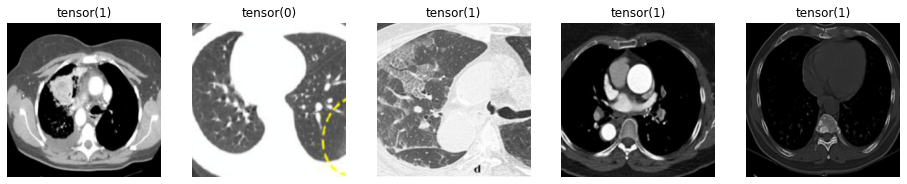

In [0]:
data_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True)

import matplotlib.pyplot as plt

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    #print(type(image))
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


# Displaying Images and other info about the train set
images, labels = next(iter(data_loader)) 
print(" Image Size",images.size())
print(" Image Size",images[ii].size())

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    ax.set_title(labels[ii])
    imshow(images[ii], ax=ax, normalize=True)

We can now move on to partitioning the training set among the different hospitals. We have 5 hospitals and therefore we have 5 teachers. **One important thing to note here is that the datasets have to be disjoint**. That is, no 2 datasets should have overlapping training examples. As mentioned earlier, differential privacy states that if an individual's data is removed from a dataset, the output of the dataset remains the same because that individual was not contributing to the dataset. Imagine we have duplicates of the same individual’s data, even if we remove one of the duplicates, the individual's data is still contributing to the output and therefore differential privacy can’t work in this case,as we cannot preserve the privacy of that individual.

So, when partitioning the training data into subsets, we have to be very cautious.

Next, we are going to partition our train set between the 5 teachers/hospitals and create trainloaders and validation loaders for each of these 5 teachers. 


In [0]:
# TEACHERS
#divide train set among teachers and create dataloaders for valid and trainsets
num_teachers = 5
valid_per = 0.2 #20% for validation
batch_size = 32

def teacher_dataloaders(transet=trainset, num_teachers=num_teachers, batch_size=batch_size, valid_per = 0.2):
  trainloaders = []
  validloaders = []
  teacher_data_len = len(trainset) // num_teachers

  # create a list of shuffled indices
  my_list = random.sample(range(1,len(trainset)), len(trainset)-1)
  random.shuffle(my_list)

  for i in range(num_teachers):
    # get particular subset of data
    indice = my_list[i*teacher_data_len: (i+1)*teacher_data_len]
    data_subset = Subset(trainset, indice)

    # split into train and validation set
    valid_size = int(len(data_subset) * valid_per)
    train_size = len(data_subset) - valid_size
    train_subset, valid_subset = torch.utils.data.random_split(data_subset, [train_size,valid_size])
    
    #create data loaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

    #add dataloaders to list
    trainloaders.append(trainloader)
    validloaders.append(validloader)
  
  return trainloaders, validloaders

# creating dataloaders
trainloaders, validloaders = teacher_dataloaders()
len(trainloaders), len(validloaders)

(5, 5)

Notice that we now have 5 trainloaders and 5 validation loaders for our teachers. Now, we create the train and validation loaders for the student (our hospital).

In [0]:
#  # STUDENT 
# split into train and validation set
valid_size = int(len(testset) * 0.2)
train_size = len(testset) - valid_size
student_train_subset, student_valid_subset = torch.utils.data.random_split(testset, [train_size,valid_size])

#create data loaders
student_train_loader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=False, num_workers=1)
student_valid_loader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(student_train_loader), len(student_valid_loader)

(6, 2)

## Step 3: Train Teachers

Now that our student and teacher datasets are ready, each hospital can train their data to create 5 different models. 

We begin by defining a simple CNN model that will be used by both the teachers and students for training. 

In [0]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() # b, 3, 32, 32
        layer1 = torch.nn.Sequential() 
        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))
 
        #b, 32, 32, 32
        layer1.add_module('relu1', torch.nn.ReLU(True)) 
        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2))
        self.layer1 = layer1
        layer4 = torch.nn.Sequential()
        layer4.add_module('fc1', torch.nn.Linear(401408, 2))       
        self.layer4 = layer4
 
    def forward(self, x):
        conv1 = self.layer1(x)
        fc_input = conv1.view(conv1.size(0), -1)
        fc_out = self.layer4(fc_input)
        
        return fc_out

Then, we define our training loop. We will not save the teacher models as they will not be useful to us after we have generated our student labels. Also, this will ensure that no copies of the models exist. 

In [0]:
def train(n_epochs, trainloader, validloader, model, optimizer, criterion, use_cuda, save_path= None, is_not_teacher=False):
    """returns trained model"""
    # # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0.0
        train_total = 0.0
        valid_correct =0.0
        valid_total = 0.0
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # initialize weights to zero
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()    
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            train_acc = 100. * train_correct / train_total
               
        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)
            valid_acc = 100. * valid_correct / valid_total
            
        # print training/validation statistics 
        print('Epoch: {} \n\tTrain Loss: {:.6f} \tTrain Acc: {:.6f} \n\tValid Loss: {:.6f} \tValid Acc: {:.6f}'.format(
            epoch,train_loss,train_acc,valid_loss,valid_acc ))
        
        ## save the student model if validation loss has decreased
        if is_not_teacher:
          if valid_loss < valid_loss_min:
              torch.save(model.state_dict(), save_path)
              print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              valid_loss_min = valid_loss

    return model


Now, we define our hyperparameters. We will be using CrossEntropyLoss and the Adam optimizer. We'll also train each teacher for 50 epochs.

In [0]:
# instantiate model and move it to GPU if available
model = SimpleCNN()
model.to(device)

#define hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)
epochs = 50

Finally, we are ready to train our teacher models.

In [0]:
# Training teachers
teacher_models = []
i = 1
for trainloader, validloader in zip(trainloaders, validloaders):
  print(" Training Teacher {}".format(i))
  teacher_model = train(epochs, trainloader, validloader, model, optimizer, criterion, True)
  teacher_models.append(teacher_model)
  i+=1
  print("="*40)

 Training Teacher 1
Epoch: 1 
	Train Loss: 52.513870 	Train Acc: 42.647059 
	Valid Loss: 53.637184 	Valid Acc: 52.941176
Epoch: 2 
	Train Loss: 58.071205 	Train Acc: 50.000000 
	Valid Loss: 15.370986 	Valid Acc: 64.705882
Epoch: 3 
	Train Loss: 20.405285 	Train Acc: 64.705882 
	Valid Loss: 26.481943 	Valid Acc: 52.941176
Epoch: 4 
	Train Loss: 20.752552 	Train Acc: 57.352941 
	Valid Loss: 17.628479 	Valid Acc: 58.823529
Epoch: 5 
	Train Loss: 17.461479 	Train Acc: 58.823529 
	Valid Loss: 9.324654 	Valid Acc: 64.705882
Epoch: 6 
	Train Loss: 13.089585 	Train Acc: 69.117647 
	Valid Loss: 11.230965 	Valid Acc: 64.705882
Epoch: 7 
	Train Loss: 14.370443 	Train Acc: 55.882353 
	Valid Loss: 21.709589 	Valid Acc: 47.058824
Epoch: 8 
	Train Loss: 11.170630 	Train Acc: 58.823529 
	Valid Loss: 4.923892 	Valid Acc: 82.352941
Epoch: 9 
	Train Loss: 3.677941 	Train Acc: 73.529412 
	Valid Loss: 9.904643 	Valid Acc: 70.588235
Epoch: 10 
	Train Loss: 11.019287 	Train Acc: 54.411765 
	Valid Loss: 6.066

## Step 4: Get Private Student Labels 

Teachers have finished training and we have 5 teacher models. We can use the models to generate labels for our hospital. Each of the 5 models model will generate one label for each image in our dataset. Therefore, we expect to have 5 generated labels for each image in our hospital dataset.


In [0]:
# get private labels
def student_train_labels(teacher_models, dataloader):
  student_labels = []

  # get label from each teacher
  for model in teacher_models:
    student_label = []
    for images,_ in dataloader:
      with torch.no_grad():
        images = images.cuda()
        outputs = model(images)
        preds = torch.argmax(torch.exp(outputs), dim=1)
      student_label.append(preds.tolist())

    # add all teacher predictions to student_labels  
    student_label = sum(student_label, [])
    student_labels.append(student_label)
  return student_labels

predicted_labels = student_train_labels(teacher_models, student_train_loader)     
predicted_labels = np.array([np.array(p) for p in predicted_labels]).transpose(1, 0)

# We see here that we have 5 labels for each image in our dataset
print(predicted_labels.shape)
# See labels of 3rd Image Scan
print(predicted_labels[3])

(163, 5)
[0 1 1 0 0]


The shape of our predicted label is (163, 5), which means there are 163 training examples in our hospital data and each teacher has generated 5 labels for each label. The predicted labels for 3rd CT image is [0 1 1 0 0]. This indicates that 3 teacher models agree that the image is negative for COVID-19 while 2 models disagree. In this case, we are going to go for the majority vote and say that this particular image is negative for COVID-19. 

## Step 5: Add Laplacian Noise
The shape of our predicted label is (163, 5), which means there are 163 training examples in our hospital data and each teacher has generated 5 labels for each image. The predicted labels for the 3rd CT image is [0 1 1 0 0]. 
This means that 3 teacher models agree that the image is negative for COVID-19 while the 2 models disagree. In this case, we select the label with the most votes and conclude that this particular image is negative for COVID-19. 

However, there may be cases when the label is not obvious.  For example, consider a case with 6 teacher models where 3 of them said the result is positive while the other 3 said it was negative. In that case, we would not be able to reach consensus and would risk misclassifying the image. This problem can be solved by adding carefully calculated random Laplacian noise to all labels provided by each teacher. Then, get the label with the maximum number of votes from all teachers. The result will be one label for each CT Scan which is a generalized classification of all teacher’s data and is differentially private. 

This is called global differential privacy as we are adding noise only after the models have been trained. We choose to add Laplacian noise because it is guaranteed to not leak information of more than epsilon and it is popularly used.																																						



We define an `add_noise()` method, which takes as input the predicted labels and a value for epsilon (ε). We can control the amount of noise we add using epsilon.


In [0]:
# Get private labels with the most votes count and add noise them
def add_noise(predicted_labels, epsilon=0.1):
  noisy_labels = []
  for preds in predicted_labels:
   
    # get labels with max votes
    label_counts = np.bincount(preds, minlength=2)
    
    # add laplacian noise to label
    epsilon = epsilon
    beta = 1/epsilon
    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)
    
    # after adding noise we get labels with max counts
    new_label = np.argmax(label_counts)
    noisy_labels.append(new_label)

  #return noisy_labels
  return np.array(noisy_labels)
  

In [0]:
# # Open File
# # resultFyle = open("output.csv",'w')

labels_with_noise = add_noise(predicted_labels, epsilon=0.1)
print(labels_with_noise)
print(labels_with_noise.shape)

[1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 1 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0
 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0
 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1]
(163,)


We can save these labels to a file and then discard the teacher models. 

In [0]:
#write to csv file
import csv
def write_csv(data):
    with open('labels.csv', 'a') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(data)

write_csv(labels_with_noise)

## Step 6: Perform PATE Analysis

Remember that the labels we got came from private information and therefore, there is some amount of information leakage that would potentially be contained within these new labels. The amount of information leaked greatly depends on the amount of noise added, which is determined by epsilon. Therefore, choosing the right epsilon value is very important and PATE can be used to perform an epsilon analysis. It can help us answer the question, **"How much information will leak through these labels if we were to publish them?"**.

In PySyft, we can use the `perform_analysis` method which takes the list of predicted labels from all teachers and the new noisy labels we just calculated as inputs and returns 2 values. The **data dependent epsilon** and the **data independent epsilon**. The main goal of the perform_analysis method is to show us the level of agreement between teachers. 

The data independent epsilon shows the maximum amount of information that can be leaked in the worst-case while the data dependent epsilon shows us the level of agreement among teachers. A small data dependent epsilon shows that teacher models have a high amount of agreement and that the models did not memorize private information (overfit) but rather made generalizations from the private data. Hence, a low data dependent epsilon indicates a low rate of privacy leakage. Another cool thing about the perform_analysis() method is that it gives us a warning when we use a surprisingly small/large epsilon.


After experimenting with different values of epsilon and the `noise_eps` variable, we decide to go with an epsilon value of 0.1 and we get a data dependent epsilon of 15.536462732485106 and a data independent epsilon of 1536462732485116.


In [0]:
# Performing PATE analysis
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=predicted_labels.T, indices=labels_with_noise_exp, noise_eps=0.1, delta=1e-5)
print('Data dependent epsilon:', data_dep_eps)
print('Data independent epsilon:', data_ind_eps)

Data dependent epsilon: 15.536462732485106
Data independent epsilon: 15.536462732485116


## Step 7: Train **Student**

Now that we have our noisy labels from the teachers, we can proceed to train our hospital data (i.e the student). Before training the model, we have to replace the old student dataloader, which contained the original labels from the dataset we downloaded, with the new labels from our teachers.  Remember that in a real life scenario, we do not have the original labels.



In [0]:
# We have to create a new training dataloader for the student with the newly created 
# labels with noise. We have to replace the old labels with the new labels
def new_student_data_loader(dataloader, noisy_labels, batch_size=32):
  image_list = []
  for image,_ in dataloader:
    image_list.append(image)
    
  data = np.vstack(image_list)
  new_dataset = list(zip(data, noisy_labels))
  new_dataloader = DataLoader(new_dataset, batch_size, shuffle=False)

  return new_dataloader

labeled_student_trainloader = new_student_data_loader(student_train_loader, labels_with_noise)
len(labeled_student_trainloader),len(student_valid_loader)

(6, 2)

Next, we train the student model. We use the newly labelled trainloader for training and use the validloader’s dataset to evaluate the performance of our model. We use the same CNN model and hyperparameters that were used to train the teachers. In this case however, we save the student model, because this is the model that will be deployed.

In [0]:

student_model = train(epochs, labeled_student_trainloader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/student.pth.tar', is_not_teacher=True)


Epoch: 1 
	Train Loss: 1.214118 	Train Acc: 74.846626 
	Valid Loss: 2.957085 	Valid Acc: 60.000000
	Validation loss decreased (inf --> 2.957085).  Saving model ...
Epoch: 2 
	Train Loss: 0.641843 	Train Acc: 73.619632 
	Valid Loss: 2.719589 	Valid Acc: 55.000000
	Validation loss decreased (2.957085 --> 2.719589).  Saving model ...
Epoch: 3 
	Train Loss: 0.315032 	Train Acc: 83.435583 
	Valid Loss: 2.181601 	Valid Acc: 65.000000
	Validation loss decreased (2.719589 --> 2.181601).  Saving model ...
Epoch: 4 
	Train Loss: 0.182551 	Train Acc: 90.797546 
	Valid Loss: 1.791358 	Valid Acc: 60.000000
	Validation loss decreased (2.181601 --> 1.791358).  Saving model ...
Epoch: 5 
	Train Loss: 0.122021 	Train Acc: 94.478528 
	Valid Loss: 1.702796 	Valid Acc: 67.500000
	Validation loss decreased (1.791358 --> 1.702796).  Saving model ...
Epoch: 6 
	Train Loss: 0.082676 	Train Acc: 98.159509 
	Valid Loss: 2.160884 	Valid Acc: 57.500000
Epoch: 7 
	Train Loss: 0.062440 	Train Acc: 99.386503 
	Valid

## Train Normal Deep Learning Model

For the sake of comparison, we train a normal model with the original labels. This model does not implement privacy in any way.

In [0]:
# Normal DL Training
normal_model = train(epochs, student_train_loader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/normal.pth.tar', is_not_teacher=True)


Epoch: 1 
	Train Loss: 1.791448 	Train Acc: 57.668712 
	Valid Loss: 0.893023 	Valid Acc: 62.500000
	Validation loss decreased (inf --> 0.893023).  Saving model ...
Epoch: 2 
	Train Loss: 1.375335 	Train Acc: 61.349693 
	Valid Loss: 2.555856 	Valid Acc: 52.500000
Epoch: 3 
	Train Loss: 2.414849 	Train Acc: 56.441718 
	Valid Loss: 2.238245 	Valid Acc: 57.500000
Epoch: 4 
	Train Loss: 0.953882 	Train Acc: 68.098160 
	Valid Loss: 1.854612 	Valid Acc: 65.000000
Epoch: 5 
	Train Loss: 1.286232 	Train Acc: 66.871166 
	Valid Loss: 1.420143 	Valid Acc: 57.500000
Epoch: 6 
	Train Loss: 0.883973 	Train Acc: 66.871166 
	Valid Loss: 0.914463 	Valid Acc: 67.500000
Epoch: 7 
	Train Loss: 0.880830 	Train Acc: 73.006135 
	Valid Loss: 0.549659 	Valid Acc: 70.000000
	Validation loss decreased (0.893023 --> 0.549659).  Saving model ...
Epoch: 8 
	Train Loss: 0.594296 	Train Acc: 71.165644 
	Valid Loss: 0.871298 	Valid Acc: 65.000000
Epoch: 9 
	Train Loss: 0.642769 	Train Acc: 68.711656 
	Valid Loss: 0.915

### Comparing Normal DL Model and Privacy Preserving Model

Now, we compare the performance of our privacy preserving student model and the normal deep learning model on the test dataset. Both models have never seen the data on in the testset before and they were both trained using the same model and hyperparameters.

In [0]:
# Create a dataloader for the test Dataset
batch_size=16
print(len(validset))
dataloader = DataLoader(validset, batch_size=batchsize, shuffle=False)


118


In [0]:
# We set a seed for the dataset to prevent it from producing different values every time it is run
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def test(dataloader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(dataloader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
       
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('\tTest Loss: {:.6f}'.format(test_loss))
    print('\tTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
print("Student Model")     
test(dataloader, student_model, criterion, True)

print("\n=======================\nNormal Model")
test(dataloader, normal_model, criterion, True)

Student Model
	Test Loss: 1.361022
	Test Accuracy: 61% (73/118)

Normal Model
	Test Loss: 1.239972
	Test Accuracy: 65% (77/118)



We take our model from an accuracy of 65% to an accuray of 61% but save many lives in the process without sacrificing privacy. Don't you think this is worth the sacrifice? I do.

### References


1.   Dwork, C., McSherry, F., Nissim, K., & Smith, A. (2006, March). [Calibrating noise to sensitivity in private data analysis. In Theory of Cryptography Conference (pp. 265-284). Springer, Berlin, Heidelberg.](https://link.springer.com/chapter/10.1007/11681878_14)

2.   Nicolas Sartor (2019, May). [Explaining Differential Privacy in 3 Levels of Difficulty](https://aircloak.com/explaining-differential-privacy/)

3.   Nicolas Papernot, et al.(2017) [Semi-supervised Knowledge Transfer for Deep Learning from Private Training Data.](https://arxiv.org/pdf/1610.05755.pdf)

4.   [Dataset Source](https://github.com/UCSD-AI4H/COVID-CT)

5.   Nicolas Papernot and Ian Goodfellow, (2018, April), [Privacy and machine learning: two unexpected allies?](http://www.cleverhans.io/privacy/2018/04/29/privacy-and-machine-learning.html)

6.   [Secure and Private AI course on Udacity](https://www.udacity.com/course/secure-and-private-ai--ud185)
